In [2]:
import os
import sys
import autograd.numpy as np
from IPython.display import display, HTML

top_level_dir = '/'.join( os.getcwd().split( '/' )[ :-2 ] )
if top_level_dir not in sys.path:
    sys.path.append( top_level_dir )

In [3]:
from GenModels.GM.States.GraphicalMessagePassing.Graph import Graph

# What is a hypergraph?
A [hypergraph](https://en.wikipedia.org/wiki/Hypergraph) is like a regular graph, except edges connect more than two nodes together.
A directed hypergraph can be thought of a collection of families (edges) linked together by people (nodes).  A [pedigree](https://en.wikipedia.org/wiki/Pedigree_chart) is an example of a hypergraph where the number of parents per edge is restricted to 2.
This repo uses hypergraph and graph interchangably, but for clarity the two are distinguished here

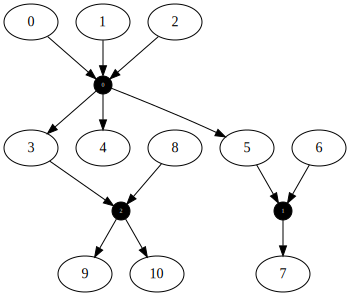

In [4]:
example = Graph()
example.addEdge( parents=[ 0, 1, 2 ], children=[ 3, 4, 5 ] )
example.addEdge( parents=[ 5, 6 ], children=[ 7 ] )
example.addEdge( parents=[ 3, 8 ], children=[ 9, 10 ] )
example.draw()

### In this picture, nodes are represented by the larger ovals and edges are represented by the smaller circles.

# Why use hypergraphs over regular graphs?
The main reason (that I think) that one can benefit from using hypergraphs over graphs is that it is possible to take into account ordering constraints in hypergraphs.  Consider the two graphs below:

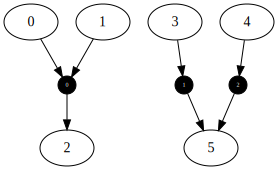

In [5]:
example = Graph()
example.addEdge( parents=[ 0, 1 ], children=[ 2 ] )
example.addEdge( parents=[ 3 ], children=[ 5 ] )
example.addEdge( parents=[ 4 ], children=[ 5 ] )
example.draw()

The joint distribution of each graph can be factored as follows:

$$P( 0, 1, 2 ) = P( 0, 1 | 2 )P( 2 )$$
$$P( 3, 4, 5 ) = P( 3, 4 | 5 )P( 5 ) = P( 3 | 5 )P( 4 | 5 )P( 5 )$$

In the hypergraph, we can see that the parents within a family are not independent when conditioned on the child like the parents in the graph are.  It is clear that the order of parents 0 and 1 matters in the hypergraph while the order of 3 and 4 does not it is not necessarily true that P( 0, 1 | 5 ) ≠ P( 1, 0 | 5 ) while P( 3, 4 | 5 ) = P( 3 | 5 )P( 4 | 5 ) = P( 4 | 5 )P( 3 | 5 ) = P( 4, 3 | 5 )
Using bayes theorem, we can see the implication that the parent facrotizations have on the generative distribution of the children.

$$P( 2 | 0, 1 ) = \frac{P( 0, 1 | 2 )P( 2 )}{P( 0 )P( 1 )}$$
$$P( 5 | 3, 4 ) = \frac{P( 3 | 5 )P( 4 | 5 )P( 5 )}{P( 3 )P( 4 )}$$

Because the joint P( 0, 1 | 2 ) does not factor further, P( 2 | 0, 1 ) must incorporate ordering the same way P( 0, 1 | 2 ) did!

# An example of where graphs aren't good enough - Punnett Squares
A [punnett square](https://en.wikipedia.org/wiki/Punnett_square) is a way to calculate the probability of a child receiving a pair of genes given its parents genes.

Assume a person can have pairs of [autosomes](https://en.wikipedia.org/wiki/Autosome) AA, Aa, aA or aa.  When reproducing, a parent passes on one of his/her two autosomes with some probability.  If we denote the autosome of person n as *n_x* ∈ { AA, Aa, aA, aa } and let child c have parents m and f, we can construct a punnet square to help us find P( c_x | m_x, f_x ).

|       | A | A |   | A | a |   | a | A |   | a | a |
| ---   |---|---|---|---|---|---|---|---|---|---|---|
| **A** | AA| AA|   | AA| Aa|   | Aa| AA|   | Aa| Aa|
| **A** | AA| AA|   | AA| Aa|   | Aa| AA|   | Aa| Aa|
|       |   |   |   |   |   |   |   |   |   |   |   |
| **A** | AA| AA|   | AA| Aa|   | Aa| AA|   | Aa| Aa|
| **a** | aA| aA|   | aA| aa|   | aa| aA|   | aa| aa|
|       |   |   |   |   |   |   |   |   |   |   |   |
| **a** | aA| aA|   | aA| aa|   | aa| aA|   | aa| aa|
| **A** | AA| AA|   | AA| Aa|   | Aa| AA|   | Aa| Aa|
|       |   |   |   |   |   |   |   |   |   |   |   |
| **a** | aA| aA|   | aA| aa|   | aa| aA|   | aa| aa|
| **a** | aA| aA|   | aA| aa|   | aa| aA|   | aa| aa|

If P( n<sub>x</sub> ) = \[ P( n<sub>x</sub>=AA ), P( n<sub>x</sub>=AA ), P( n<sub>x</sub>=AA ), P( n<sub>x</sub>=AA ) \] and we want to relate P( c<sub>x</sub> | m<sub>x</sub>, f<sub>x</sub> ) to P( m<sub>x</sub> ) and P( f<sub>x</sub> ), it can be shown that there does not exist a way to write P( c<sub>x</sub> | m<sub>x</sub>, f<sub>x</sub> ) = p( c<sub>x</sub> | m<sub>x</sub> )q( c<sub>x</sub> | f<sub>x</sub> )

This implies that a graph cannot fully describe the dynamics of genetic inheritance.  However a hypergraph can by letting $$P( c_x=AA | m_x, f_x ) = \begin{pmatrix}
1.0 & 0.5 & 0.5 & 0.0 \\
0.5 & 0.25 & 0.25 & 0.0 \\
0.5 & 0.25 & 0.25 & 0.0 \\
0.0 & 0.0 & 0.0 & 0.0
\end{pmatrix}$$
$$P( c_x=Aa | m_x, f_x ) = \begin{pmatrix}
0.0 & 0.5 & 0.5 & 1.0 \\
0.0 & 0.25 & 0.25 & 0.5 \\
0.0 & 0.25 & 0.25 & 0.5 \\
0.0 & 0.0 & 0.0 & 0.0
\end{pmatrix}$$
$$P( c_x=aA | m_x, f_x ) = \begin{pmatrix}
0.0 & 0.0 & 0.0 & 0.0 \\
0.5 & 0.25 & 0.25 & 0.0 \\
0.5 & 0.25 & 0.25 & 0.0 \\
1.0 & 0.5 & 0.5 & 0.0
\end{pmatrix}$$
$$P( c_x=aa | m_x, f_x ) = \begin{pmatrix}
0.0 & 0.0 & 0.0 & 0.0 \\
0.0 & 0.25 & 0.25 & 0.5 \\
0.0 & 0.25 & 0.25 & 0.5 \\
0.0 & 0.5 & 0.5 & 1.0
\end{pmatrix}$$

#### What about an example where order matters?

The previous example happens to be symmetric, so is not important.  The punnett square for chromosomal inheritance highlights the importance order makes - there must be a male and a female for reproduction.  The punnett square for X-linked recessive inheritance shows this clearly

|       | X | X |   | X | x |   | x | X |   | x | x |
| ---   |---|---|---|---|---|---|---|---|---|---|---|
| **X** | XX| XX|   | XX| Xx|   | Xx| XX|   | Xx| Xx|
| **Y** | XY| XY|   | XY| xY|   | xY| XY|   | xY| xY|
|       |   |   |   |   |   |   |   |   |   |   |   |
| **x** | xX| xX|   | xX| xx|   | xx| xX|   | xx| xx|
| **Y** | XY| XY|   | XY| xY|   | xY| XY|   | xY| xY|











The research part of this repo uses hypergraphs to do inference over genotypes and phenotypes in pedigrees using latent state space models.  This method exploits the entire structure of the family tree while still being able to work with random occurences such as de-novo mutations, incomplete penetrance, no diagnosis and other ways that a phenotype will not show up on the pedgree even if the corresponding genotype is present.

# Notation

Keeping track of what goes where is difficult when the number of node states grows exponentially, so to in order to be able to describe what is going on, new notation must be introduced.

$$
\text{ Let } n \text{ denote a node and } e \text{ denote an edge } \\
\text{ An up edge of a node refers to the edge that it is a child of } \\
\text{ Down edges of a node refers to all of the edges that node is a parent of } \\ 
\hat{n} \text{ - } n, \text{ but treated as a parent } \\
\check{n} \text{ - } n, \text{ but treated as a child } \\
n( e ) \text{ - Set of all nodes in } e \\
e( n ) \text{ - Set of all edges } n \text{ is in } \\
\wedge( n ) \text{ - Set of parents for node } n \\
\vee( n ) \text{ - Set of all children of } n \text{ over all edges } \\
\wedge( e ) \text{ - Set of parent nodes in e } \\
\vee( e ) \text{ - Set of child nodes in e } \\
\wedge( ., !n ) \text{ - Set of nodes selected by }\wedge\text{ but not n } \\
\vee( ., !n ) \text{ - Set of nodes selected by }\vee\text{ but not n } \\
\uparrow( n ) \text{ - Set of all nodes that can be reached by traversing the node's up edge.  This includes } n_y \\
\downarrow( n, e ) \text{ - Set of all nodes that can be reached by traversing down node's down edge e.  This doesn't include } n_y \\
!( n, e ) = \text{ nodes that can be reached without traversing edge e.  This doesn't include } n_y \\
(.)_x \text{ - Latent state for the set of nodes selected } \\
(.)_y \text{ - Observed state for set of nodes selected }
$$